In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
import seaborn as sns
from datetime import datetime
import tensorflow
from numpy.random import seed
import math
from sklearn.metrics import mean_squared_error

## Data loading, preprocessing and graphical analysis

In [2]:
df = pd.read_csv('D:/UW/3rd semester/ML2/Project/Group/Time-Series Analysis Dataset.csv',parse_dates=True)

In [3]:
df.head()

,datetime_local,temperature,humidity,dew_point,wind_bearing,wind_speed,wind_gust,pressure,uv_index,ozone,precip_intensity,icon
0,01/10/2019 00:00,26,1,22.01,101,3.08,6.42,1008.45,0,268.6,0.0,partly-cloudy-night
1,01/10/2019 01:00,25,1,22.06,105,2.94,6.28,1008.24,0,269.1,0.0,partly-cloudy-night
2,01/10/2019 02:00,25,1,22.06,106,2.82,6.08,1007.90,0,269.7,0.0,partly-cloudy-night
3,01/10/2019 03:00,24,1,21.87,106,2.63,5.74,1007.61,0,270.4,0.0,partly-cloudy-night
4,01/10/2019 04:00,23,1,21.53,100,2.39,5.30,1007.51,0,271.3,0.0,partly-cloudy-night


In [4]:
df.describe()

,temperature,humidity,dew_point,wind_bearing,wind_speed,wind_gust,pressure,uv_index,ozone,precip_intensity
count,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000
mean,27.797595,0.541082,15.871303,139.523046,2.267114,3.616974,1011.535411,1.641283,276.195792,0.009820
std,4.305725,0.498809,3.065238,118.438353,0.755191,1.608687,1.932765,2.493683,2.788063,0.036247
min,19.000000,0.000000,5.740000,0.000000,0.600000,0.840000,1005.970000,0.000000,268.600000,0.000000
25%,24.000000,0.000000,14.025000,44.000000,1.780000,2.460000,1010.235000,0.000000,274.600000,0.000000
50%,27.000000,1.000000,15.710000,105.000000,2.200000,3.220000,1011.430000,0.000000,276.100000,0.000000
75%,32.000000,1.000000,17.990000,217.500000,2.780000,4.345000,1012.675000,3.000000,277.800000,0.000000
max,36.000000,1.000000,22.350000,359.000000,4.180000,10.540000,1016.900000,8.000000,284.900000,0.420000


In [5]:
#NA check
df.isnull().any()

datetime_local      False
temperature         False
humidity            False
dew_point           False
wind_bearing        False
wind_speed          False
wind_gust           False
pressure            False
uv_index            False
ozone               False
precip_intensity    False
icon                False
dtype: bool

Let's check for a correlation between various measurements, such as temperature, pressure, wind speed and dew point.

(-0.3230129920679137, 1.3965037596913926e-13)

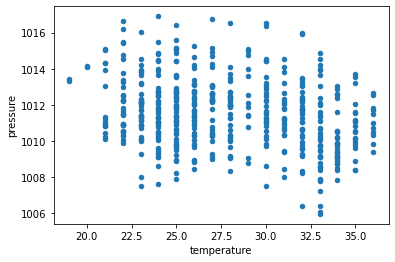

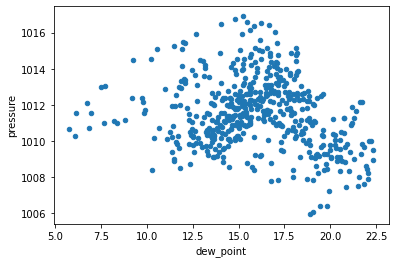

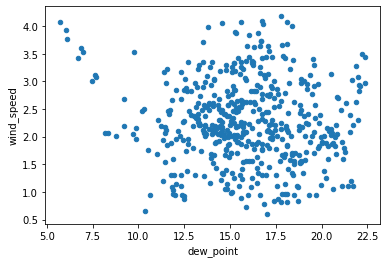

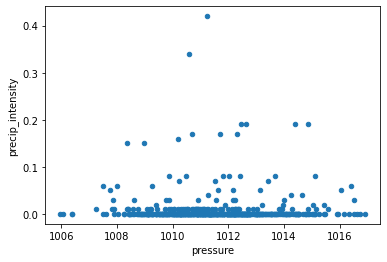

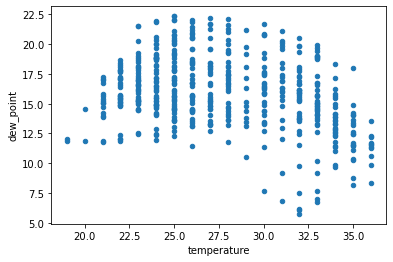

In [6]:
#Checking for correlation between random variables
import scipy.stats
df.plot(x="temperature", y="pressure", kind="scatter")
scipy.stats.pearsonr(df["temperature"], df["pressure"])
df.plot(x="dew_point", y="pressure", kind="scatter")
scipy.stats.pearsonr(df["dew_point"], df["pressure"])
df.plot(x="dew_point", y="wind_speed", kind="scatter")
scipy.stats.pearsonr(df["dew_point"], df["wind_speed"])
df.plot(x="pressure", y="precip_intensity", kind="scatter")
scipy.stats.pearsonr(df["pressure"], df["precip_intensity"])
df.plot(x="temperature", y="dew_point", kind="scatter")
scipy.stats.pearsonr(df["temperature"], df["dew_point"])

There is no significant correlation between the variables

In [7]:
df.loc[:,'datetime_local'] =  pd.to_datetime(df['datetime_local'], format='%d/%m/%Y %H:%M')

In [8]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['datetime_local'])
print(train_dates.head(5))
print(train_dates.tail(5))

0   2019-10-01 00:00:00
1   2019-10-01 01:00:00
2   2019-10-01 02:00:00
3   2019-10-01 03:00:00
4   2019-10-01 04:00:00
Name: datetime_local, dtype: datetime64[ns]
494   2019-10-21 14:00:00
495   2019-10-21 15:00:00
496   2019-10-21 16:00:00
497   2019-10-21 17:00:00
498   2019-10-21 18:00:00
Name: datetime_local, dtype: datetime64[ns]


In [9]:
#convert categorical to number
for i in df.select_dtypes('object').columns:
    le = LabelEncoder().fit(df[i])
    df[i] = le.transform(df[i]) 

Let's prepare the training data

In [10]:
#Variables for training
cols = list(df)[1:]
print(cols)

['temperature', 'humidity', 'dew_point', 'wind_bearing', 'wind_speed', 'wind_gust', 'pressure', 'uv_index', 'ozone', 'precip_intensity', 'icon']


In [11]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

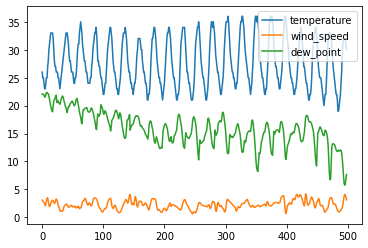

In [12]:
#descriptive plots
df_for_training['temperature'].plot.line()
df_for_training['wind_speed'].plot.line()
df_for_training['dew_point'].plot.line()
plt.legend()

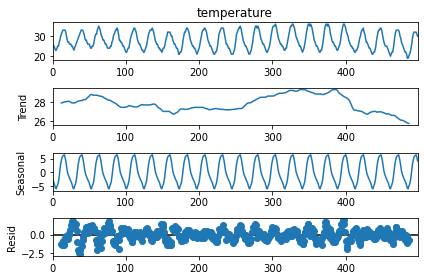

In [13]:
#target variable easonality check
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df['temperature'], period = 24)
results.plot();

## Data preparation

In [14]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [15]:
n_future = 12   # Number of days we want to look into the future based on the past days.
n_past = 96     # Number of past days we want to use to predict the future.

In [16]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

In [17]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [18]:
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (392, 96, 11).
trainY shape == (392, 1).


## Multivariate LSTM model development

In [19]:
seed(321)
tensorflow.random.set_seed(123)

# define the LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(64, activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True)))
model.add(Bidirectional(LSTM(32, activation='tanh', return_sequences=False)))
model.add(Dropout(0.05))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse', metrics=[tensorflow.keras.metrics.RootMeanSquaredError(name='rmse')])

# fit the model
history = model.fit(trainX, trainY, epochs=20, batch_size=8, validation_split=0.3, verbose=1)

Epoch 1/20
35/35 [==============================] - 15s 183ms/step - loss: 0.3045 - rmse: 0.5518 - val_loss: 0.1234 - val_rmse: 0.3513
Epoch 2/20
35/35 [==============================] - 4s 104ms/step - loss: 0.0557 - rmse: 0.2360 - val_loss: 0.1058 - val_rmse: 0.3253
Epoch 3/20
35/35 [==============================] - 3s 100ms/step - loss: 0.0364 - rmse: 0.1908 - val_loss: 0.1085 - val_rmse: 0.3293
Epoch 4/20
35/35 [==============================] - 3s 99ms/step - loss: 0.0256 - rmse: 0.1600 - val_loss: 0.0976 - val_rmse: 0.3124
Epoch 5/20
35/35 [==============================] - 3s 100ms/step - loss: 0.0186 - rmse: 0.1364 - val_loss: 0.0991 - val_rmse: 0.3148
Epoch 6/20
35/35 [==============================] - 4s 107ms/step - loss: 0.0158 - rmse: 0.1256 - val_loss: 0.1100 - val_rmse: 0.3317
Epoch 7/20
35/35 [==============================] - 4s 104ms/step - loss: 0.0175 - rmse: 0.1322 - val_loss: 0.0954 - val_rmse: 0.3088
Epoch 8/20
35/35 [==============================] - 4s 105ms/s

In [20]:
np.mean(history.history['val_rmse'])

0.32381250858306887

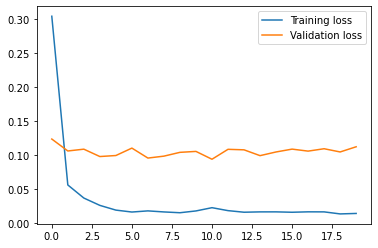

In [21]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [22]:
n_past = 96 #start position (min = 1)
n_days_for_prediction=168 #horizon

In [23]:
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq="H").tolist()

In [24]:
prediction1 = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

In [25]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies1 = np.repeat(prediction1, df_for_training.shape[1], axis=-1)
y_pred_future1 = scaler.inverse_transform(prediction_copies1)[:,0]

C:\Users\Pavilion\AppData\Local\Temp/ipykernel_22072/534184316.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['datetime_local']=pd.to_datetime(original['datetime_local'])
C:\Users\Pavilion\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Pavilion\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments wit

<AxesSubplot:xlabel='datetime_local', ylabel='temperature'>

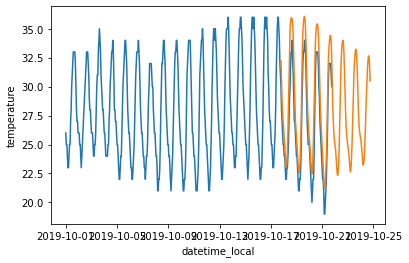

In [26]:
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i)
    
df_forecast = pd.DataFrame({'datetime_local':np.array(forecast_dates), 'temperature':y_pred_future1})
#df_forecast['datetime_local']=pd.to_datetime(df_forecast['datetime_local'], format = '%d/%m/%Y %H:%M')


original = df[['datetime_local', 'temperature']]
original['datetime_local']=pd.to_datetime(original['datetime_local'])
original = original.loc[original['datetime_local'] >= '2019-10-01']

sns.lineplot(original['datetime_local'], original['temperature'])
sns.lineplot(df_forecast['datetime_local'], df_forecast['temperature'])

In [27]:
testScore1 = math.sqrt(mean_squared_error(df['temperature'][499-168:], y_pred_future1))
print('Test RSME Score: %.2f Celsius' %(testScore1))

Test RSME Score: 1.23 Celsius


## Model tuning

In [28]:
mse_list_2 = []
for past in [24,48,96,192]:
    for future in [12, 24, 36, 48]:
        for n1 in [4,8, 12, 16, 32, 64]:
            for n2 in [4,8, 12, 16, 32, 64]:
                n_future = future 
                n_past = past
                trainX = []
                trainY = []
                for i in range(n_past, len(df_for_training_scaled) - n_future +1):
                    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
                    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])
                trainX, trainY = np.array(trainX), np.array(trainY)
                seed(321)
                tensorflow.random.set_seed(123)
                model = Sequential()
                model.add(Bidirectional(LSTM(n1, activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True)))
                model.add(Bidirectional(LSTM(n2, activation='tanh', return_sequences=False)))
                model.add(Dense(trainY.shape[1]))
                model.compile(optimizer='adam', loss='mse')
                print(past, future, n1,n2)
                history = model.fit(trainX, trainY, epochs=15, batch_size=8, validation_split=0.3, verbose=1)
                mse_list_2.append([past, future, n1,n2,np.mean(history.history['val_loss'])])

24 12 4 4
Epoch 1/15
41/41 [==============================] - 11s 69ms/step - loss: 1.0819 - val_loss: 1.0917
Epoch 2/15
41/41 [==============================] - 1s 25ms/step - loss: 0.8737 - val_loss: 0.9378
Epoch 3/15
41/41 [==============================] - 1s 25ms/step - loss: 0.6766 - val_loss: 0.7744
Epoch 4/15
41/41 [==============================] - 1s 26ms/step - loss: 0.4533 - val_loss: 0.6092
Epoch 5/15
41/41 [==============================] - 1s 26ms/step - loss: 0.2625 - val_loss: 0.4592
Epoch 6/15
41/41 [==============================] - 1s 25ms/step - loss: 0.1505 - val_loss: 0.3912
Epoch 7/15
41/41 [==============================] - 1s 27ms/step - loss: 0.1019 - val_loss: 0.3593
Epoch 8/15
41/41 [==============================] - 1s 26ms/step - loss: 0.0770 - val_loss: 0.3690
Epoch 9/15
41/41 [==============================] - 1s 26ms/step - loss: 0.0623 - val_loss: 0.3700
Epoch 10/15
41/41 [==============================] - 1s 26ms/step - loss: 0.0516 - val_loss: 0.370

In [31]:
df_mse_2 = pd.DataFrame(mse_list_2, columns = ['past', 'future', 'n1', 'n2', 'mse'])

In [32]:
df_mse_2.sort_values('mse')

,past,future,n1,n2,mse
322,96,12,64,32,0.096346
316,96,12,32,32,0.103543
269,48,48,12,64,0.109995
311,96,12,16,64,0.112496
340,96,24,12,32,0.118890
...,...,...,...,...,...
511,168,36,8,8,1.040022
512,168,36,8,12,1.051751
361,96,36,4,8,1.091092
505,168,36,4,8,1.118387


In [35]:
mse_list3 = []
for drop in [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
    for batch in [4, 8, 16, 32, 64]:
        seed(321)
        tensorflow.random.set_seed(123)
        model = Sequential()
        model.add(Bidirectional(LSTM(64, activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True)))
        model.add(Bidirectional(LSTM(32, activation='tanh', return_sequences=False)))
        model.add(Dropout(drop))
        model.add(Dense(trainY.shape[1]))
        model.compile(optimizer='adam', loss='mse')
        print(drop,batch)
        history = model.fit(trainX, trainY, epochs=20, batch_size=batch, validation_split=0.3, verbose=1)
        mse_list3.append([drop, batch, np.mean(history.history['val_loss'])])

0 4
Epoch 1/20
50/50 [==============================] - 33s 458ms/step - loss: 0.3023 - val_loss: 0.3450
Epoch 2/20
50/50 [==============================] - 20s 408ms/step - loss: 0.0338 - val_loss: 0.3619
Epoch 3/20
50/50 [==============================] - 21s 420ms/step - loss: 0.0280 - val_loss: 0.3623
Epoch 4/20
50/50 [==============================] - 20s 404ms/step - loss: 0.0202 - val_loss: 0.3337
Epoch 5/20
50/50 [==============================] - 20s 406ms/step - loss: 0.0190 - val_loss: 0.2789
Epoch 6/20
50/50 [==============================] - 21s 421ms/step - loss: 0.0158 - val_loss: 0.3520
Epoch 7/20
50/50 [==============================] - 20s 404ms/step - loss: 0.0128 - val_loss: 0.3289
Epoch 8/20
50/50 [==============================] - 20s 400ms/step - loss: 0.0134 - val_loss: 0.3159
Epoch 9/20
50/50 [==============================] - 21s 419ms/step - loss: 0.0117 - val_loss: 0.3882
Epoch 10/20
50/50 [==============================] - 21s 415ms/step - loss: 0.0117 - va

In [38]:
df_mse_3 = pd.DataFrame(mse_list3, columns = ['dropout', 'batch',  'mse'])

In [39]:
df_mse_3.sort_values('mse').head()

,dropout,batch,mse
10,0.10,4,0.313451
11,0.10,8,0.315155
15,0.20,4,0.316528
20,0.30,4,0.317059
5,0.05,4,0.317490


## Multivariate MLP model 

In [40]:
X_train = df_for_training_scaled[:, 1:df_for_training.shape[1]]
y_train = df_for_training_scaled[:, 0]

In [41]:
X_train, y_train = np.array(X_train), np.array(y_train)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (284, 168, 11).
trainY shape == (284, 1).


In [42]:
n_col = X_train.shape[1]
# define model
seed(321)
tensorflow.random.set_seed(123)
model2 = Sequential()
model2.add(Dense(64, activation='tanh', input_shape= (n_col,)))
model2.add(Dense(32, activation='tanh'))
model2.add(Dropout(0.05))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse', metrics=[tensorflow.keras.metrics.RootMeanSquaredError(name='rmse')])

In [43]:
# fit the model
history2 = model2.fit(X_train, y_train, epochs=30, batch_size=8, validation_split=0.3, verbose=1)

Epoch 1/30
44/44 [==============================] - 1s 7ms/step - loss: 0.2863 - rmse: 0.5350 - val_loss: 0.2570 - val_rmse: 0.5070
Epoch 2/30
44/44 [==============================] - 0s 4ms/step - loss: 0.1822 - rmse: 0.4269 - val_loss: 0.2811 - val_rmse: 0.5302
Epoch 3/30
44/44 [==============================] - 0s 4ms/step - loss: 0.1777 - rmse: 0.4216 - val_loss: 0.2863 - val_rmse: 0.5351
Epoch 4/30
44/44 [==============================] - 0s 3ms/step - loss: 0.1733 - rmse: 0.4163 - val_loss: 0.2840 - val_rmse: 0.5329
Epoch 5/30
44/44 [==============================] - 0s 3ms/step - loss: 0.1692 - rmse: 0.4113 - val_loss: 0.2664 - val_rmse: 0.5161
Epoch 6/30
44/44 [==============================] - 0s 3ms/step - loss: 0.1494 - rmse: 0.3865 - val_loss: 0.2390 - val_rmse: 0.4888
Epoch 7/30
44/44 [==============================] - 0s 3ms/step - loss: 0.1473 - rmse: 0.3838 - val_loss: 0.2447 - val_rmse: 0.4946
Epoch 8/30
44/44 [==============================] - 0s 3ms/step - loss: 0.15

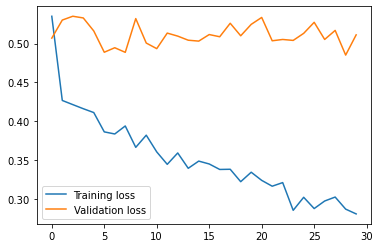

In [44]:
plt.plot(history2.history['rmse'], label='Training loss')
plt.plot(history2.history['val_rmse'], label='Validation loss')
plt.legend()

In [45]:
np.mean(history2.history['val_rmse'])

0.5112030605475107

C:\Users\Pavilion\AppData\Local\Temp/ipykernel_22072/3306428551.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['datetime_local']=pd.to_datetime(original['datetime_local'])
C:\Users\Pavilion\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Pavilion\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments wi

<AxesSubplot:xlabel='datetime_local', ylabel='temperature'>

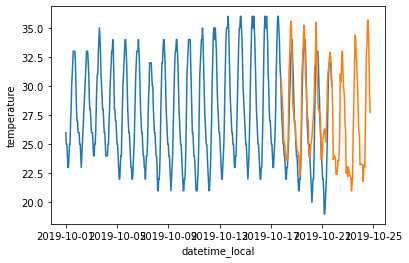

In [46]:
prediction2 = model2.predict(X_train[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction
prediction_copies2 = np.repeat(prediction2, df_for_training.shape[1], axis=-1)
y_pred_future2 = scaler.inverse_transform(prediction_copies2)[:,0]

forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i)
    
df_forecast = pd.DataFrame({'datetime_local':np.array(forecast_dates), 'temperature':y_pred_future2})
#df_forecast['datetime_local']=pd.to_datetime(df_forecast['datetime_local'], format = '%d/%m/%Y %H:%M')


original = df[['datetime_local', 'temperature']]
original['datetime_local']=pd.to_datetime(original['datetime_local'])
original = original.loc[original['datetime_local'] >= '2019-10-01']

sns.lineplot(original['datetime_local'], original['temperature'])
sns.lineplot(df_forecast['datetime_local'], df_forecast['temperature'])

In [47]:
testScore2 = math.sqrt(mean_squared_error(df['temperature'][499-168:], y_pred_future2))
print('Test RSME Score: %.2f Celsius' %(testScore2))

Test RSME Score: 2.10 Celsius


## MLP model with a single variable

In [49]:
df_1 = pd.read_csv('D:/UW/3rd semester/ML2/Project/Group/Time-Series Analysis Dataset.csv', usecols = [1])

In [50]:
df_1.head(5)

,temperature
0,26
1,25
2,25
3,24
4,23


In [51]:
df_1 = df_1.astype('float32')

In [52]:
scaler = MinMaxScaler(feature_range=(0,1))
df_1 = scaler.fit_transform(df_1)

In [53]:
train_size = int(len(df_1)*0.7)
test_size = len(df_1) - train_size
train,test = df_1[0:train_size,:],df_1[train_size:len(df),:] 

In [54]:
def to_sequences (df_1, seq_size = 1):
    x = []
    y = []
    for i in range(len(df_1)-seq_size-1):
        window = df_1[i:(i+seq_size),0]
        x.append(window)
        y.append(df_1[i+seq_size,0])
    return np.array(x),np.array(y)

In [55]:
seq_size = 5

In [56]:
trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

In [57]:
print('Shape of training set: {}'.format (trainX.shape))
print('Shape of test set: {}'.format (testX.shape))

Shape of training set: (343, 5)
Shape of test set: (144, 5)


In [58]:
seed(321)
tensorflow.random.set_seed(123)

model3 = Sequential()
model3.add(Dense(64, input_dim=seq_size, activation='tanh'))
model3.add(Dense(32, activation='tanh'))
model3.add(Dense(1))
model3.compile(loss='mean_squared_error', optimizer='adam', metrics=[tensorflow.keras.metrics.RootMeanSquaredError(name='rmse')])
print(model3.summary())

Model: "sequential_614"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_616 (Dense)           (None, 64)                384       
                                                                 
 dense_617 (Dense)           (None, 32)                2080      
                                                                 
 dense_618 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
_________________________________________________________________
None


In [59]:
history3 = model3.fit(trainX, trainY, validation_data=(testX, testY), verbose=2, epochs=20)

Epoch 1/20
11/11 - 1s - loss: 0.5107 - rmse: 0.7147 - val_loss: 0.0415 - val_rmse: 0.2038 - 639ms/epoch - 58ms/step
Epoch 2/20
11/11 - 0s - loss: 0.0608 - rmse: 0.2465 - val_loss: 0.0961 - val_rmse: 0.3100 - 56ms/epoch - 5ms/step
Epoch 3/20
11/11 - 0s - loss: 0.0498 - rmse: 0.2231 - val_loss: 0.0252 - val_rmse: 0.1587 - 54ms/epoch - 5ms/step
Epoch 4/20
11/11 - 0s - loss: 0.0247 - rmse: 0.1572 - val_loss: 0.0276 - val_rmse: 0.1661 - 54ms/epoch - 5ms/step
Epoch 5/20
11/11 - 0s - loss: 0.0187 - rmse: 0.1366 - val_loss: 0.0176 - val_rmse: 0.1325 - 68ms/epoch - 6ms/step
Epoch 6/20
11/11 - 0s - loss: 0.0137 - rmse: 0.1171 - val_loss: 0.0142 - val_rmse: 0.1193 - 55ms/epoch - 5ms/step
Epoch 7/20
11/11 - 0s - loss: 0.0107 - rmse: 0.1037 - val_loss: 0.0108 - val_rmse: 0.1039 - 67ms/epoch - 6ms/step
Epoch 8/20
11/11 - 0s - loss: 0.0081 - rmse: 0.0898 - val_loss: 0.0083 - val_rmse: 0.0909 - 63ms/epoch - 6ms/step
Epoch 9/20
11/11 - 0s - loss: 0.0063 - rmse: 0.0791 - val_loss: 0.0064 - val_rmse: 0.0

In [60]:
trainPredict = model3.predict(trainX)
testPredict = model3.predict(testX)

In [61]:
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

In [62]:
testY_inverse = scaler.inverse_transform([testY])
trainY_inverse = scaler.inverse_transform([trainY])

In [63]:
trainScore3 = math.sqrt(mean_squared_error(trainY_inverse[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' %(trainScore3))

testScore3 = math.sqrt(mean_squared_error(testY_inverse[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' %(testScore3))

Train Score: 0.83 RMSE
Test Score: 0.92 RMSE


In [64]:
trainPredictPlot = np.empty_like(df_1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size,:] = trainPredict

In [65]:
testPredictPlot = np.empty_like(df_1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(df_1)-1,:] = testPredict

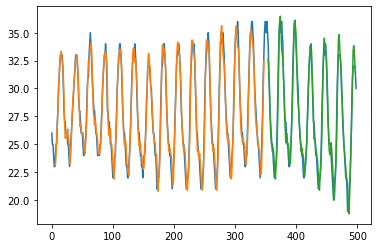

In [66]:
plt.plot(scaler.inverse_transform(df_1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

## LSTM with a single varibale

In [67]:
print('Shape of training set: {}'.format (trainX.shape))
print('Shape of test set: {}'.format (testX.shape))

Shape of training set: (343, 5)
Shape of test set: (144, 5)


In [68]:
trainX = np.reshape(trainX, (trainX.shape[0],1,trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0],1, testX.shape[1]))

In [69]:
print('Shape of training set: {}'.format (trainX.shape))
print('Shape of test set: {}'.format (testX.shape))

Shape of training set: (343, 1, 5)
Shape of test set: (144, 1, 5)


In [70]:
seed(321)
tensorflow.random.set_seed(123)

model4 = Sequential()
model4.add(Bidirectional(LSTM(64, activation = 'tanh',input_shape=(None, seq_size), return_sequences = True)))
model4.add(Bidirectional(LSTM(32, activation = 'tanh',return_sequences = False)))
model4.add(Dense(1))
model4.compile(loss='mean_squared_error', optimizer = 'adam', metrics=[tensorflow.keras.metrics.RootMeanSquaredError(name='rmse')])

In [71]:
history4 = model4.fit(trainX, trainY, validation_data=(testX, testY), verbose=2, epochs=20)

Epoch 1/20
11/11 - 12s - loss: 0.2764 - rmse: 0.5258 - val_loss: 0.1911 - val_rmse: 0.4371 - 12s/epoch - 1s/step
Epoch 2/20
11/11 - 0s - loss: 0.1346 - rmse: 0.3669 - val_loss: 0.0633 - val_rmse: 0.2517 - 115ms/epoch - 10ms/step
Epoch 3/20
11/11 - 0s - loss: 0.0432 - rmse: 0.2078 - val_loss: 0.0465 - val_rmse: 0.2156 - 119ms/epoch - 11ms/step
Epoch 4/20
11/11 - 0s - loss: 0.0340 - rmse: 0.1844 - val_loss: 0.0337 - val_rmse: 0.1834 - 134ms/epoch - 12ms/step
Epoch 5/20
11/11 - 0s - loss: 0.0267 - rmse: 0.1633 - val_loss: 0.0309 - val_rmse: 0.1758 - 139ms/epoch - 13ms/step
Epoch 6/20
11/11 - 0s - loss: 0.0246 - rmse: 0.1568 - val_loss: 0.0277 - val_rmse: 0.1666 - 133ms/epoch - 12ms/step
Epoch 7/20
11/11 - 0s - loss: 0.0218 - rmse: 0.1477 - val_loss: 0.0252 - val_rmse: 0.1588 - 134ms/epoch - 12ms/step
Epoch 8/20
11/11 - 0s - loss: 0.0194 - rmse: 0.1391 - val_loss: 0.0219 - val_rmse: 0.1479 - 129ms/epoch - 12ms/step
Epoch 9/20
11/11 - 0s - loss: 0.0168 - rmse: 0.1296 - val_loss: 0.0187 - va

In [72]:
model4.summary()

Model: "sequential_615"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1226 (Bidirec  (None, 1, 128)           35840     
 tional)                                                         
                                                                 
 bidirectional_1227 (Bidirec  (None, 64)               41216     
 tional)                                                         
                                                                 
 dense_619 (Dense)           (None, 1)                 65        
                                                                 
Total params: 77,121
Trainable params: 77,121
Non-trainable params: 0
_________________________________________________________________


In [73]:
trainPredict = model4.predict(trainX)
testPredict = model4.predict(testX)

In [74]:
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)
testY_inverse = scaler.inverse_transform([testY])
trainY_inverse = scaler.inverse_transform([trainY])

In [75]:
trainScore4 = math.sqrt(mean_squared_error(trainY_inverse[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' %(trainScore4))

testScore4 = math.sqrt(mean_squared_error(testY_inverse[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' %(testScore4))

Train Score: 0.97 RMSE
Test Score: 1.16 RMSE


In [76]:
trainPredictPlot = np.empty_like(df_1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size,:] = trainPredict

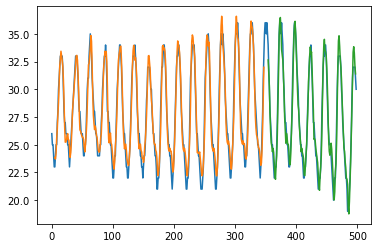

In [77]:
plt.plot(scaler.inverse_transform(df_1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

In [78]:
total_score = []

In [79]:
total_score.append(testScore1)
total_score.append(testScore2)
total_score.append(testScore3)
total_score.append(testScore4)

In [80]:
total_score

[1.2299560524577418,
 2.0966433441030334,
 0.9178617972068661,
 1.1588988106221818]

In [81]:
df_total = pd.DataFrame(total_score, ['Multi LSTM', 'Multi MLP',  'Single MLP', 'Single LSTM'], columns = ['RSME'])
df_total.sort_values('RSME')

,RSME
Single MLP,0.917862
Single LSTM,1.158899
Multi LSTM,1.229956
Multi MLP,2.096643
